# Final Network Training and Analysis

#  Import packages

In [1]:
import numpy as np
import h5py
import glob
import re
import tensorflow as tf
import random
import cmcrameri as cmc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,LeakyReLU,GlobalAveragePooling2D,ReLU

np.set_printoptions(precision=3, suppress=True)

2024-04-15 23:17:15.137868: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 23:17:15.163211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 23:17:15.608877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Setup GPU

First, follow instructions [here](https://gist.github.com/zrruziev/b93e1292bf2ee39284f834ec7397ee9f), or alternatively run:
```bash
for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
```

Some paths need to be explicitly established in terminal in order for the GPU to be recognised (for CUDNN), as well as the right version of ptxas:
```bash
export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
export LD_LIBRARY_PATH=${CUDNN_PATH}/lib
export PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:$PATH
```
These can be integrated into the .bashrc file, or otherwise must be submitted upon every OS start before analysis. Failing to do the first 2 will automatically engage the CPU tensorflow, and failing to only do the last one will likely yield a gpu error.

Don't forget to restart your IDE (e.g. VSCode) after running the commands above, otherwise it will likely run from the virtual environment configuration before the commands executed. This way we avoid tensorflow skipping registration of GPU devices.

We do this as a workaround for [this error](https://github.com/tensorflow/tensorflow/issues/42738):

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(tf.config.list_physical_devices('GPU'), tf.test.gpu_device_name())
print("TF Version:",tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] /device:GPU:0
TF Version: 2.16.1


2024-04-15 23:17:17.770553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 23:17:17.817548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 23:17:17.817725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Import and prepare data

In [3]:
import sys
sys.path.append('./..')
from src.training_utils import data_load, extract_floats, split_dataset, predict_multi_by_name, plot_violin_and_statistics,cross_mean_err_calculator

In [4]:
#all alphas: [0.016,0.023,0.034,0.050,0.073,0.107,0.157,0.231,0.340,0.500]
#all densities: [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]
x,y,shape = data_load(alphas=[0.016,0.023,0.034,0.050,0.073,0.107,0.157,0.231,0.340,0.500], densities=[0.25],orientation=True,scrambled=False)

We have N * number of unique alpha snapshots total, we split them into training set and a validation set with the ratio 80/20:

In [5]:
x_train, y_train, x_val, y_val = split_dataset(x,y,last=int(len(x)*0.2)) #len(x)*1 means no training, only validation!

Number of unique alpha:  10
Shape of x:  (10000, 128, 128, 1)
Shape of y:  (10000,)
Size of training data:  8000
Size of validation data:  2000


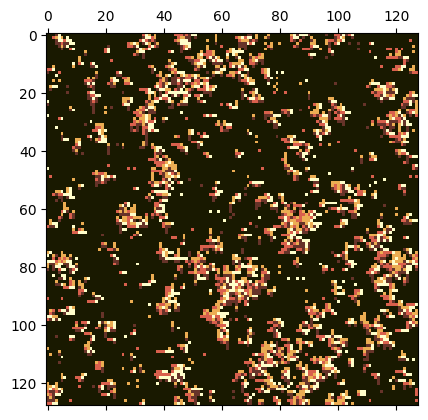

In [6]:
plt.matshow(x_val[500],cmap='cmc.lajolla')

# Setup and train our model

Workaround for dropout not working:

In [7]:
import contextlib

@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)

**Run this after analysis to reset model and release RAM before changing the architecture**

In [ ]:
import gc

K.clear_session()
del prediction
del model
del history

print("Collected: ", gc.collect())

## Setting up the model's architecture

In [8]:
fixed_seed = 296 #choose seed (comment out if not needed)

if 'fixed_seed' in locals():
    keras.utils.set_random_seed(fixed_seed)
    print("Running program with fixed seed:",fixed_seed)
else:
    print("Running program with random seed.")

def make_net(shape):
    model = Sequential()

    model.add(Conv2D(filters=3, kernel_size=(3, 3), padding="same", input_shape=shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(filters=4, kernel_size=(5, 5), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(filters=6, kernel_size=(5, 5), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    with options({"layout_optimizer": False}):
        model.add(Dropout(0.1))

    model.add(Dense(units=128, activation="relu"))

    with options({"layout_optimizer": False}):
        model.add(Dropout(0.1))

    model.add(Dense(units=3, activation="relu"))

    model.add(Flatten())
    model.add(Dense(units=1, activation="linear"))
    return model

Running program with fixed seed: 296


In [9]:
model = make_net(shape)

/home/danielle/venv-tflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-15 23:17:38.048130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 23:17:38.048352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 23:17:38.048

## Optimizer

In [10]:
#optimizer = keras.optimizers.Adam(learning_rate=0.0003)
optimizer = keras.optimizers.SGD(learning_rate=0.001) #usual learning rate for our model is 0.006
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 4)      │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 6)      │           606 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 6)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,279 (8.90 KB)

 Trainable params: 2,253 (8.80 KB)

 Non-trainable params: 26 (104.00 B)

## Training and evaluation

Before training, these are the "predictions":

I0000 00:00:1713219462.626488  114964 service.cc:145] XLA service 0x79ea28003860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713219462.626514  114964 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-04-15 23:17:42.631484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 23:17:42.659190: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

I0000 00:00:1713219463.238868  114964 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Shape of prediction :  (2000, 1)
Pearson's correlation coeff:  -0.7828850912968115


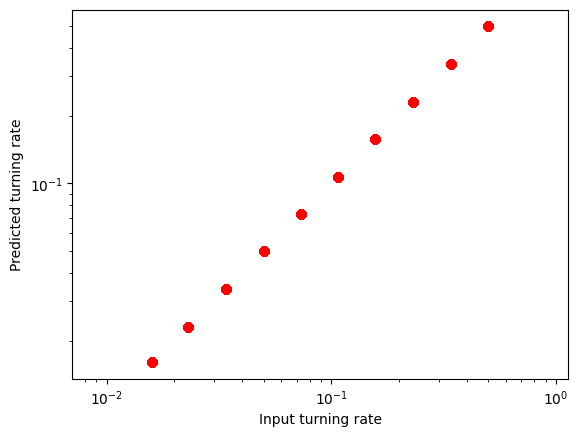

In [11]:
prediction = model.predict(x_val, batch_size=64)
print("Shape of prediction : ", np.shape(prediction))

plt.plot(y_val, prediction.T[0], 'o', c='k', alpha=0.25)
plt.plot(y_val, y_val, 'o', color='r')

print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)
plt.xlabel("Input turning rate")
plt.ylabel("Predicted turning rate")
plt.axis("equal")
plt.xscale("log")
plt.yscale("log")

Actual:  0.5
Predicted:  -0.03462998


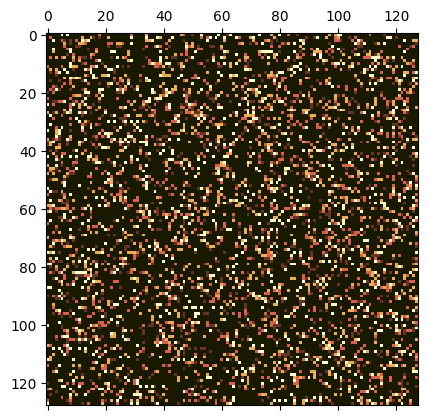

In [12]:
demo_idx = 100
plt.matshow(x_val[demo_idx],cmap='cmc.lajolla')
print("Actual: ", y_val[demo_idx])
print("Predicted: ", prediction.T[0][demo_idx])

We can play with the architecture and see how the untrained predictions can change too.

## Run the training

In [13]:
epochs=60 #usual epoch number is 60
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=True,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1362 - mae: 0.1362 - val_loss: 0.1165 - val_mae: 0.1173
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1147 - mae: 0.1147 - val_loss: 0.1177 - val_mae: 0.1186
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1117 - mae: 0.1117 - val_loss: 0.1059 - val_mae: 0.1067
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1039 - mae: 0.1039 - val_loss: 0.0955 - val_mae: 0.0961
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0906 - mae: 0.0906 - val_loss: 0.0776 - val_mae: 0.0782
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0825 - mae: 0.0825 - val_loss: 0.0686 - val_mae: 0.0691
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0751 - mae: 0.0751 - val_loss: 0.0650 - val_mae: 0.0656
Epoch 8/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0714 - mae: 0.0714 - val_loss: 0.0618 - val_mae: 0.0623
Epoch 9/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

In [14]:
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

Evaluate on test data:
Test loss: [0.03025873564183712, 0.0305156409740448]


# Alternatively, load a trained model

In [ ]:
name = "orientation0296"
model = tf.keras.models.load_model(f'../models/{name}.keras')
model.summary()

# Analyse training results

In [15]:
prediction = model.predict(x_val)
print("Shape of prediction : ", np.shape(prediction))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of prediction :  (2000, 1)


Prediction means and standard deviations.
Actual value 0.016: Average = 0.02372 +- 0.00586; Expected value within 1.317 stdevs of mean
Actual value 0.023: Average = 0.03020 +- 0.00500; Expected value within 1.441 stdevs of mean
Actual value 0.034: Average = 0.03804 +- 0.00598; Expected value within 0.675 stdevs of mean
Actual value 0.05: Average = 0.05067 +- 0.00795; Expected value within 0.084 stdevs of mean
Actual value 0.073: Average = 0.07274 +- 0.01338; Expected value within 0.020 stdevs of mean
Actual value 0.107: Average = 0.11119 +- 0.02288; Expected value within 0.183 stdevs of mean
Actual value 0.157: Average = 0.18778 +- 0.03124; Expected value within 0.985 stdevs of mean
Actual value 0.231: Average = 0.26336 +- 0.03662; Expected value within 0.884 stdevs of mean
Actual value 0.34: Average = 0.31593 +- 0.03034; Expected value within 0.793 stdevs of mean
Actual value 0.5: Average = 0.36436 +- 0.02081; Expected value within 6.519 stdevs of mean
With accuracy 0.005, overlap rat

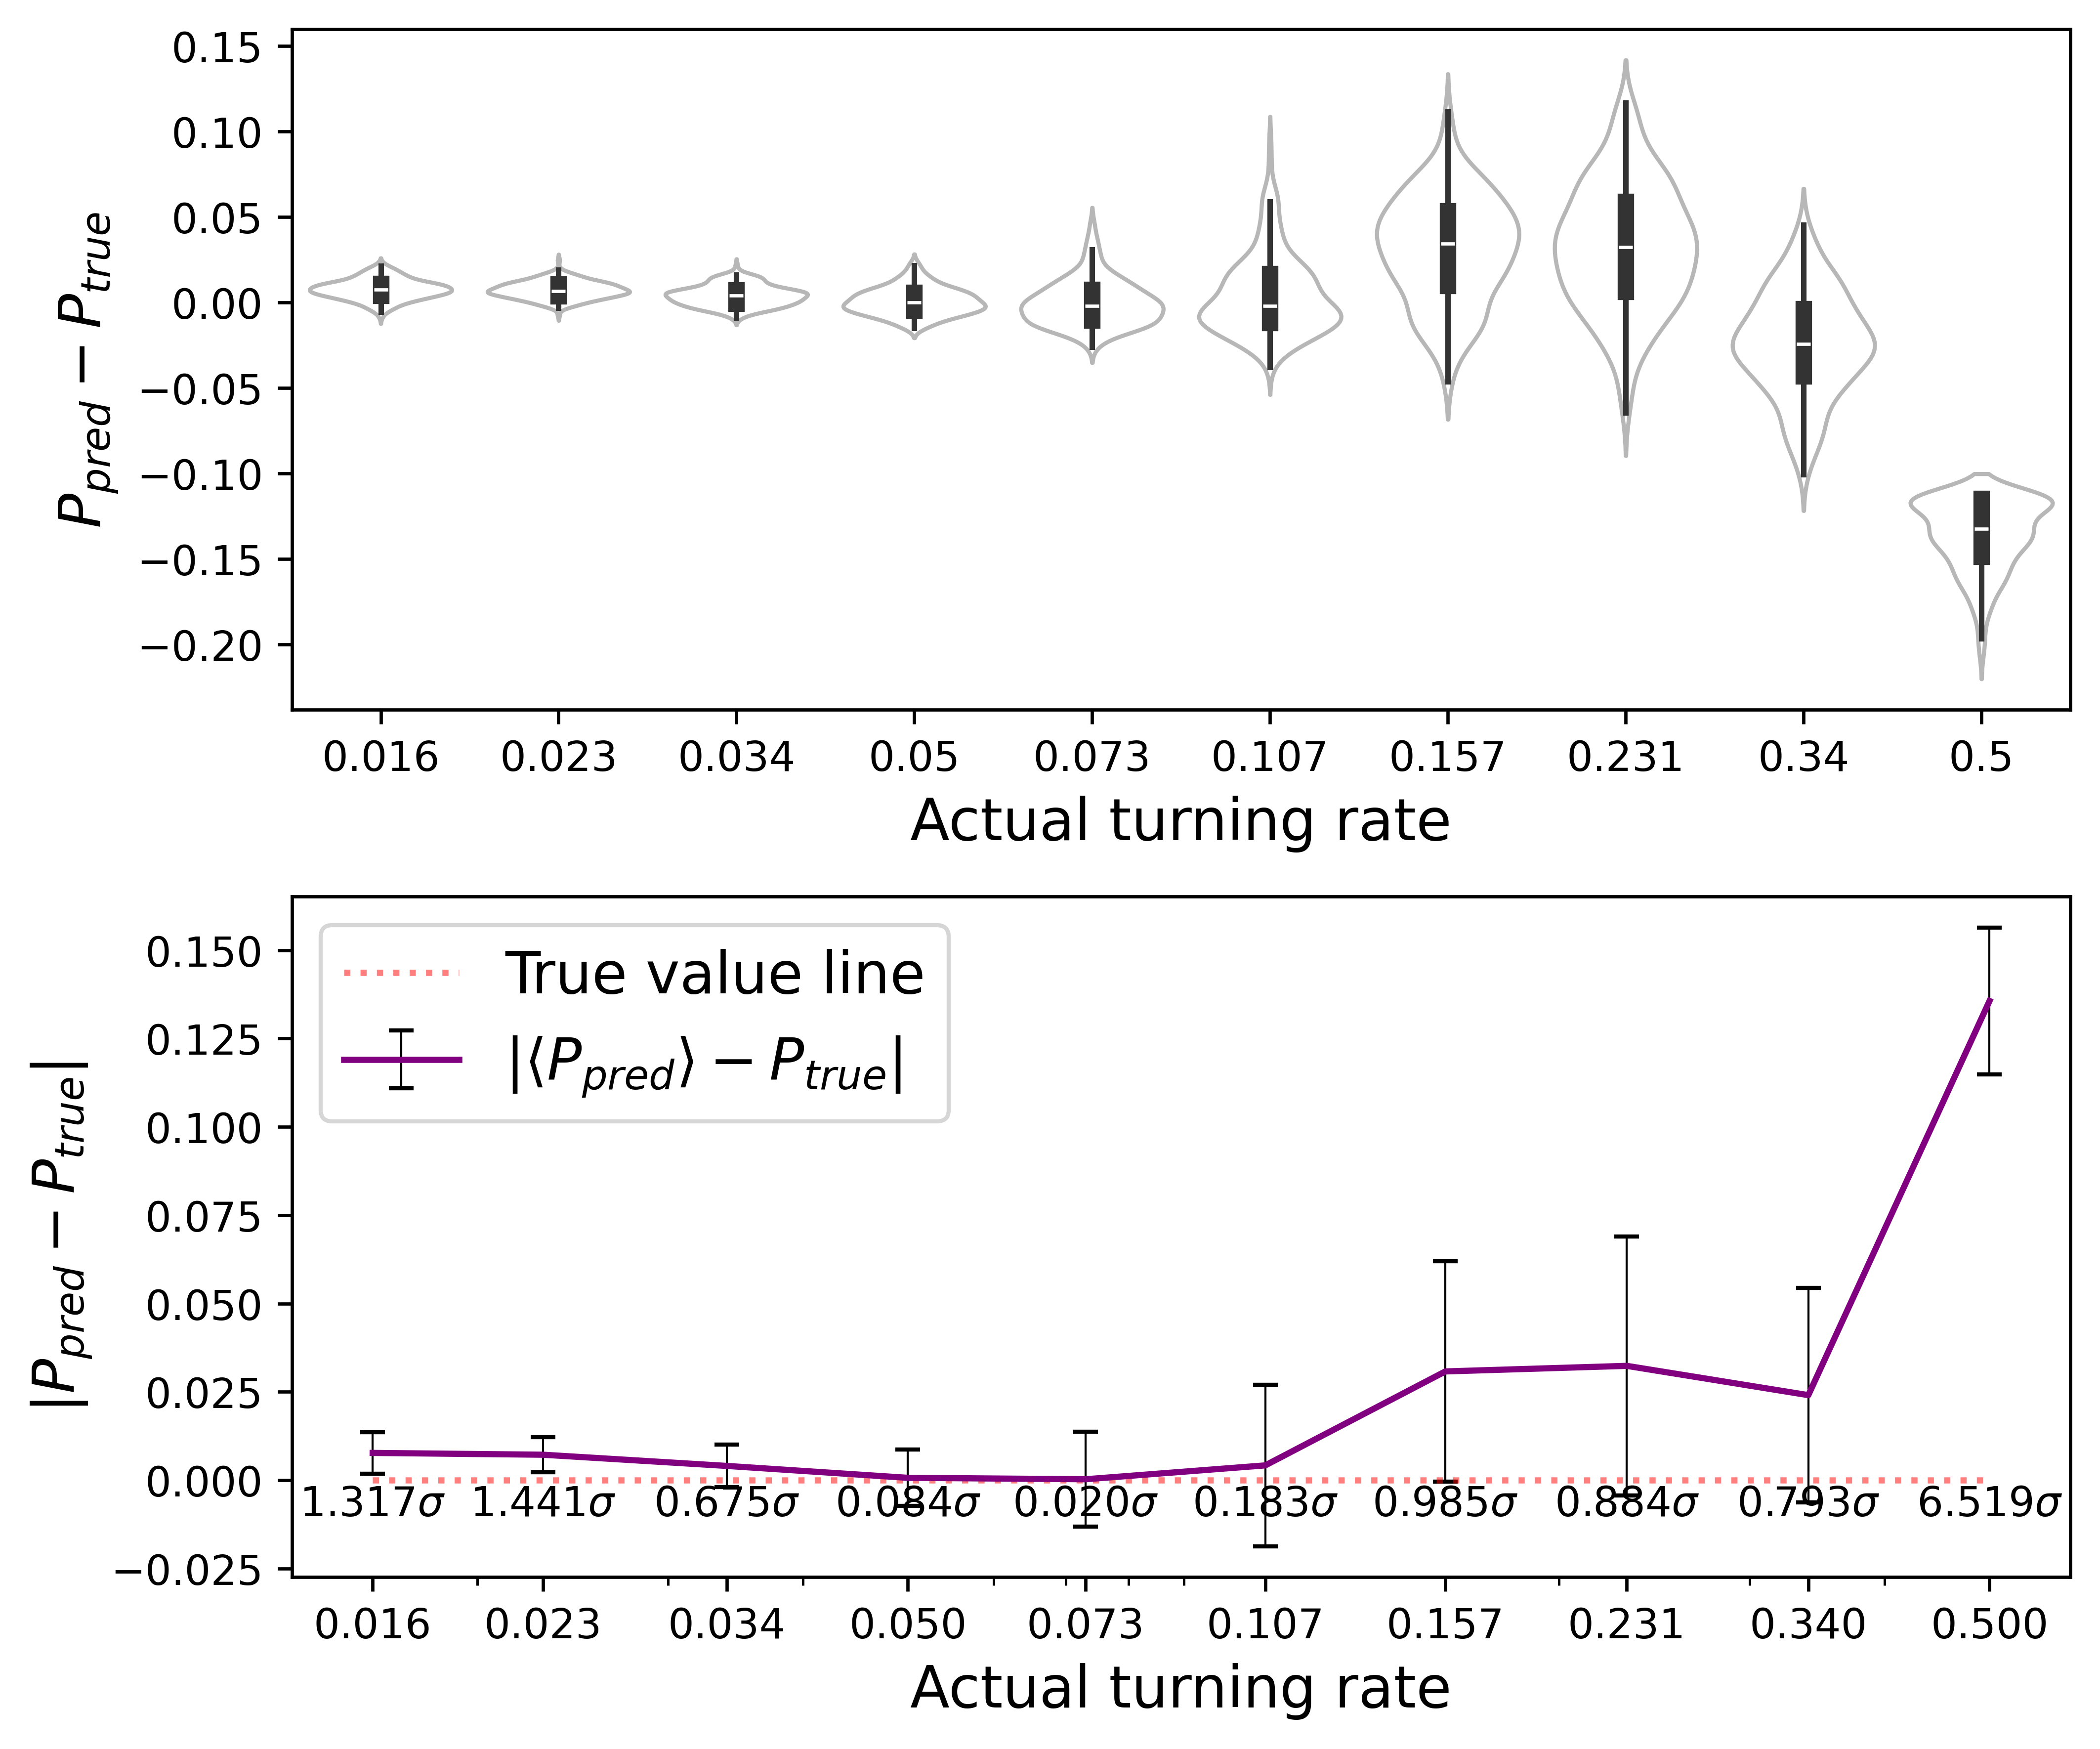

In [16]:
from cmcrameri import cm
import seaborn as sns
import pandas as pd

bins = np.logspace(-6,-1,10, base=2)*0.85

v = prediction.T[0]

colors = cm.batlowS(np.digitize(v, bins))
colors_actual = cm.batlowS(np.digitize(np.unique(y_val),bins))

fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(7,6),dpi=600)

df = pd.DataFrame()
df.insert(0, "predicted", v - y_val)
df.insert(1, "actual", y_val)

sns.violinplot(
    ax=ax1,
    data=df,
    x="actual",
    y="predicted",
    color="w",
    alpha=0.7,
    density_norm="width",
    linewidth=1,
    inner="box",
    inner_kws={"box_width": 4, "color": "0.2"},
    )

ax1.set_xlabel("Actual turning rate",fontsize=14)
ax1.set_ylabel(r"$P_{pred}-P_{true}$",fontsize=14)

std = []
means = []
overlap = []
std_div = []
accuracy = 5e-3
print ("Prediction means and standard deviations.")
for val in np.unique(y_val):
    v_mapped = v[np.where(y_val == val)]
    stdev = np.std(v_mapped)
    std.append(stdev)
    mean = np.mean(v_mapped)
    overlap.append((val + accuracy >= np.min(v_mapped)) & (val - accuracy <= np.max(v_mapped)))
    within_std = abs(val-mean)/stdev
    print (f"Actual value {val}: Average = {mean:.5f} +- {stdev:.5f}; Expected value within {within_std:.3f} stdevs of mean")
    std_div.append(within_std)

print(f"With accuracy {accuracy}, overlap ratio:", np.sum(overlap)/len(overlap))
print("(Min, Max, Avg) STD:", np.min(std), np.max(std), np.mean(std))
print("Pearson's correlation coeff: ", pearsonr(y_val, v).statistic)



for val in np.unique(y_val):
    v_mapped = v[np.where(y_val == val)]
    means.append(np.mean(v_mapped))

ax2.errorbar(np.sort(np.unique(y_val)),np.abs(means-np.sort(np.unique(y_val))),yerr=(std),ecolor='black',elinewidth=0.5,capsize=3,color='purple',label=r'$|\langle P_{pred} \rangle -P_{true}|$')
ax2.plot(np.sort(np.unique(y_val)),np.zeros(np.unique(y_val).shape[0]),color='red',label='True value line',linestyle='dotted',alpha=0.5)


ax2.legend(loc='upper left',fontsize=14)

counter = 0
for i in np.sort(np.unique(y_val)):
    ax2.text(i,-0.01,f"${std_div[counter]:.3f} \sigma$",ha="center")
    counter = counter + 1

ax2.set_xscale("log")
ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax2.set_xticks(np.unique(y_val))

ax2.set_xlabel("Actual turning rate",fontsize=14)
ax2.set_ylabel(r"$|P_{pred}-P_{true}|$",fontsize=14)

fig.tight_layout()
#plt.suptitle("CNN Turning Rate Predictions Against Actual Values")

Text(0, 0.5, 'Predicted turning rate')

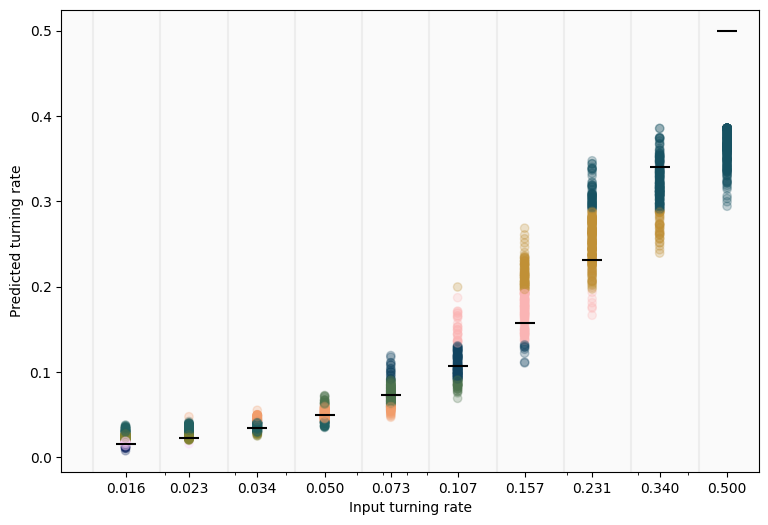

In [17]:
fig,ax=plt.subplots(1,1,figsize=(9,6))

ax.scatter(y_val, v, c=colors, alpha=0.25)
ax.scatter(np.unique(y_val), np.unique(y_val), marker="_", color='k', s=200)

ax.set_xscale("log")
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(y_val))

ax.set_facecolor([0.98,0.98,0.98,1])

for val in bins:
    ax.axvline(val, alpha=0.05, c='k')

ax.set_xlabel("Input turning rate")
ax.set_ylabel("Predicted turning rate")


Text(0, 0.5, 'Loss Function')

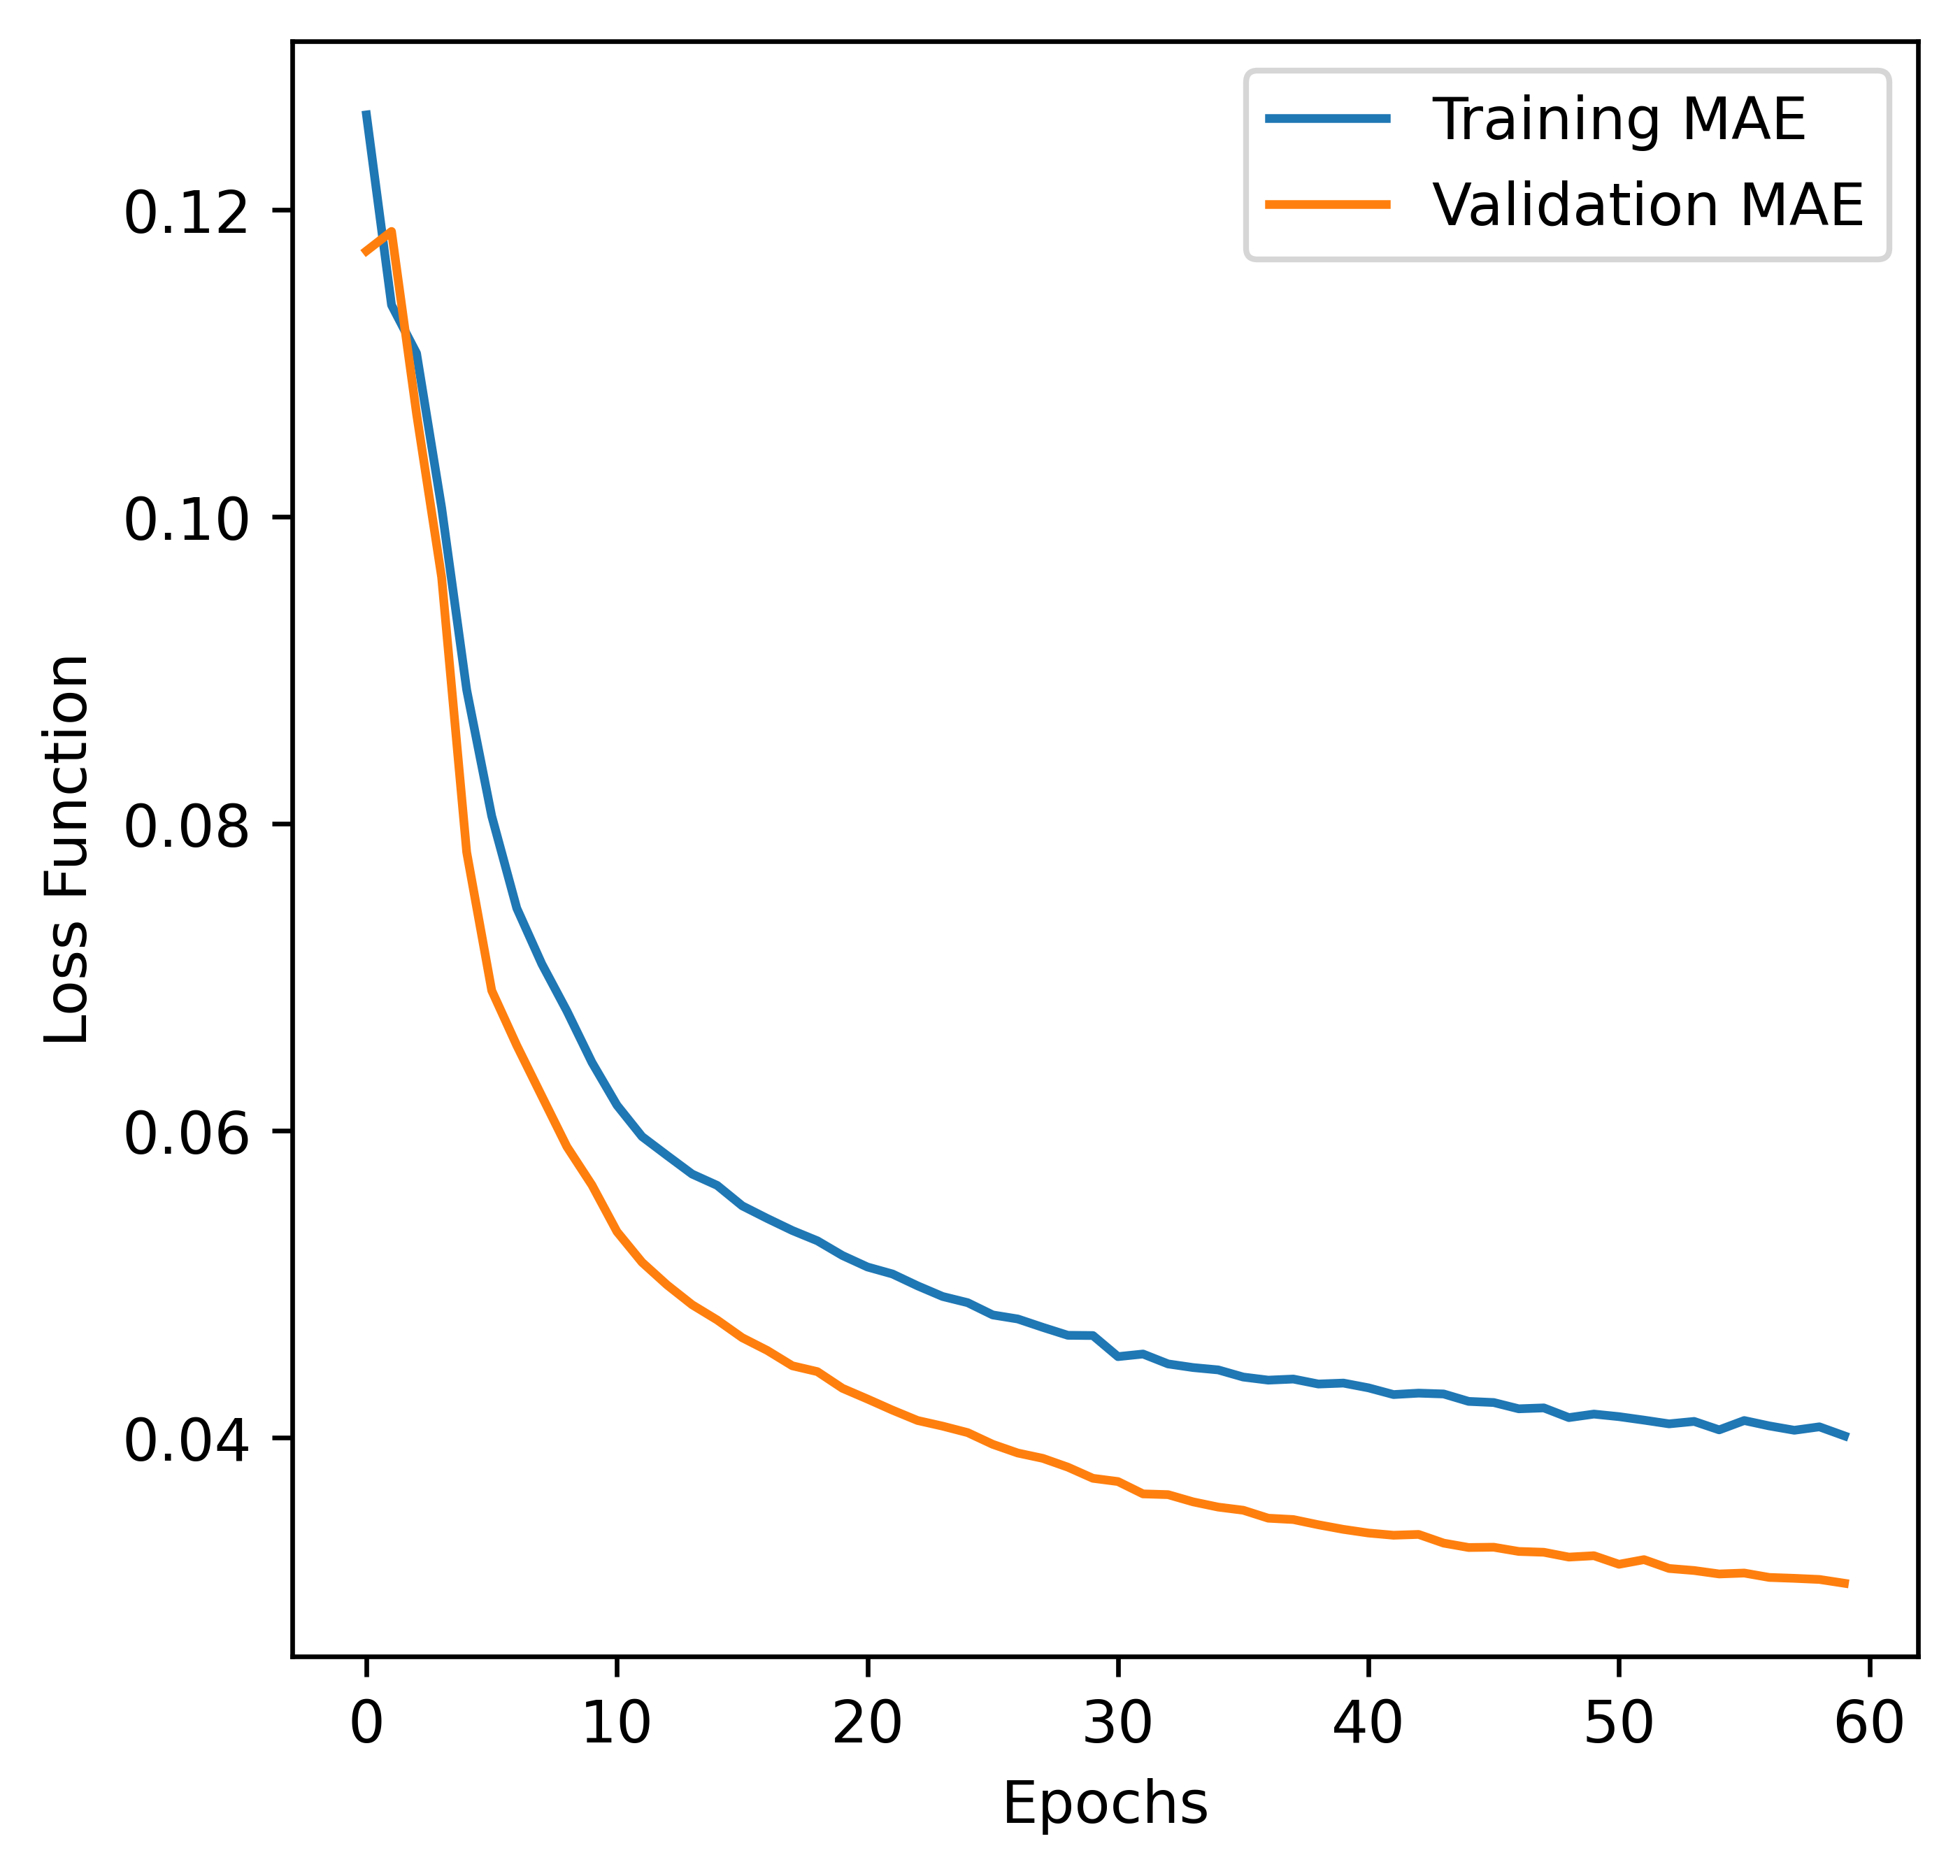

In [24]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 5),dpi=600)
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss Function")
#plt.title('Training and Validation MAE')

### Kernel analysis

In [ ]:
filters, biases = model.layers[0].get_weights()
print (filters.shape[-1])
for k in range(filters.shape[-1]):
  f = filters[:, :, :, k]
  plt.matshow(f.squeeze())
  plt.colorbar()

# Save model (if needed)

In [ ]:
name = "bracelet1891"
model.save(f"../models/{name}.keras")